### Imports & utils

In [1]:
%pip install datasets transformers[torch]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 21.2.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!wget https://raw.githubusercontent.com/akshaybhalotia/yc_company_scraper/main/data/yc_essential_data.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
from __future__ import annotations
import typing
from dataclasses import dataclass, field
import warnings
from contextlib import contextmanager
import itertools
import functools
import logging
from ast import literal_eval

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional
import transformers
import transformers.modeling_outputs
import datasets
import bp_mll

In [6]:
@contextmanager
def localize_globals(*exceptions: str, restore_values: bool = True):
    exceptions: typing.Set[str] = set(exceptions)

    old_globals: typing.Dict[str, typing.Any] = dict(globals())
    allowed: typing.Set[str] = set(old_globals.keys())
    allowed.update(exceptions)

    yield None

    new_globals: typing.Dict[str, typing.Any] = globals()

    for name in tuple(new_globals.keys()):
        if name not in allowed:
            del new_globals[name]

    if not restore_values:
        return

    new_globals.update(
        {k: v for k, v in old_globals.items() if k not in exceptions}
    )

In [7]:
logging.basicConfig(
    level=logging.INFO,
    format="[{levelname}] {message}",
    style="{",
)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data preprocessing

In [9]:
data: pd.DataFrame = pd.read_csv("yc_essential_data.csv")

# Limit to the columns we're interested in
data = data[["name", "one_liner", "long_description", "tags"]]

# Convert tags to a list
data["tags"] = data["tags"].apply(literal_eval)
assert isinstance(data.at[0, "tags"], list), "Didn't work!"

# Okay, apparently an empty string makes a nan by default
# Gotta reverse it
data["one_liner"].replace(
    to_replace=np.nan,
    value="",
    inplace=True,
)

data["long_description"].replace(
    to_replace=np.nan,
    value="",
    inplace=True,
)

# Preview the results
data.head()

,name,one_liner,long_description,tags
0,Wufoo,Online form builder.,Wufoo is a web application that helps anybody ...,"[SaaS, Productivity]"
1,Project Wedding,,"Finding wedding vendors is hard. In 2007, a co...",[]
2,Clustrix,,Clustrix provides the leading scale-out relati...,[]
3,Inkling,,"Inkling, based in Chicago, Illinois, offers co...",[]
4,Audiobeta,,AudioBeta develops web-based applications that...,[]


In [10]:
data.sample(10)

,name,one_liner,long_description,tags
3926,Value Voting,Platform to defeat political extremism through...,Value Voting develops political targeting soft...,[Marketplace]
2063,Terapify,The leading mental healthcare platform in Lati...,Terapify offers high-quality on-demand mental ...,"[Mental Health Tech, Consumer Health Services,..."
4059,Rally,Rally is Zoom for social events,Rally is what Zoom breakouts should have been....,"[Collaboration, Video, Social]"
2608,Gas Pos,Modern Point of Sale for Gas Stations and Truc...,"We have taken an incredibly monopolized, overp...","[Fintech, SaaS, B2B]"
4043,Atmos,"The entire homebuilding process, all online",,"[Housing, Proptech]"
1894,HUBUC,Global Card Issuing and Payment Processing Engine,HUBUC P1 is a lightning-fast global card issui...,"[Fintech, Payments, B2B, API, Infrastructure]"
3722,Superpowered AI,API for Retrieval Augmented Generation,Superpowered AI makes it easy to build product...,"[Artificial Intelligence, Developer Tools, Gen..."
1518,Outschool,A live online learning platform that empowers ...,Outschool is an innovative education platform ...,"[Education, Marketplace]"
2781,Syncro,Zapier for scaling high-touch talent management,"Integrate your HRIS, ATS, and communication st...","[Workflow Automation, Recruiting]"
2155,Codeball,AI-Powered Code Review,"Codeball finds bugs in your Pull Requests, let...","[Artificial Intelligence, Developer Tools, SaaS]"


// TODO: Don't use the name, remove it from long_description as well?

In [11]:
# Gather all unique tags
with localize_globals("all_tags"):
    tags_set: set[str] = set(itertools.chain.from_iterable(data["tags"]))
    
    tags_list: list[str] = sorted(tags_set)
    # A special tag at index 0
    tags_list.insert(0, "[DUMMY]")

    all_tags: pd.Series = pd.Series(tags_list)

all_tags

0                  [DUMMY]
1         3D Printed Foods
2              3D Printing
3                       AI
4             AI Assistant
              ...         
325         Women's Health
326    Workflow Automation
327              eLearning
328                eSports
329                   web3
Length: 330, dtype: object

### Pretrained models

In [55]:
tokenizer: transformers.DistilBertTokenizer = transformers.DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased",
    device=device,
)

# nlp_model: transformers.DistilBertModel = transformers.DistilBertModel.from_pretrained(
#     "distilbert-base-uncased",
# )

In [13]:
MAX_TOKENS: int = 512
EMBEDDING_SIZE: int = 768

### Dataset preparation

In [56]:
with localize_globals("complete_dataset", "col_pad_len"):
    def preprocess(batch: dict[str, typing.Any]) -> dict[str, typing.Any]:
        for column in (
            "name",
            "one_liner",
            "long_description",
        ):
            tmp = tokenizer(
                batch[column],
                truncation=True,
                padding="max_length",
                max_length=MAX_TOKENS,
                return_tensors="pt",
                add_special_tokens=True,
            ).data

            # logging.info(f"!! {tmp['input_ids'].shape}, {tmp['attention_mask'].shape}")
            batch[column] = tmp["input_ids"].to(device)
            batch[f"{column}_mask"] = tmp["attention_mask"].to(device)
            
            batch[f"orig_{column}"] = batch[column]

        # TODO: Since this is the target, process it separately?
        if "tags" in batch:
            batch["tags"] = torch.stack([
                torch.tensor(all_tags.apply(tags.__contains__), dtype=torch.float, device=device)
                for tags in batch["tags"]
            ])
            batch["tags"][:, 0] = 1.  # Dummy tag is always present
            batch["orig_tags"] = batch["tags"]

        return batch

    complete_dataset = (
        datasets.Dataset
        .from_pandas(data)
        # .with_format(None)
        .with_transform(preprocess)
    )

complete_dataset

Dataset({
    features: ['name', 'one_liner', 'long_description', 'tags'],
    num_rows: 4423
})

In [57]:
with localize_globals("train_dataset", "val_dataset", "test_dataset"):
    train_test_split = complete_dataset.train_test_split(test_size=0.2)
    train_dataset = train_test_split["train"]

    test_val_split = train_test_split["test"].train_test_split(test_size=0.3)
    val_dataset = test_val_split["train"]
    test_dataset = test_val_split["test"]

train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['name', 'one_liner', 'long_description', 'tags'],
     num_rows: 3538
 }),
 Dataset({
     features: ['name', 'one_liner', 'long_description', 'tags'],
     num_rows: 619
 }),
 Dataset({
     features: ['name', 'one_liner', 'long_description', 'tags'],
     num_rows: 266
 }))

In [58]:
class NLPWrapperModule(nn.Module):
    """
    Wraps an nlp module and performs the following pre- and postprocessing:
    
    - Takes a dictionary and `**`-unwraps it for the submodule's input
    - Takes `.last_hidden_state` from the submodule's result and returns only it
    
    Note that the wrapper is opaque, hiding the parameters of the underlying
    NLP module to avoid tuning and saving it.
    """
    
    bert: nn.Module
    
    def __init__(self) -> None:
        super().__init__()
        
        bert: transformers.DistilBertModel = transformers.DistilBertModel.from_pretrained(
            "distilbert-base-uncased",
        )
        
        bert.to(device)
        
        # I can't afford to also tune BERT, nor do I need to
        bert.train(False)
        for param in bert.parameters():
            param.requires_grad = False
        
        # I want it to exclude bert from the perceived parameters
        object.__setattr__(self, "bert", bert)
        
        assert not self._modules, f"Opacity failure: {self._modules}"
    
    def forward(
        self,
        params: typing.Mapping[str, torch.Tensor],
    ) -> torch.Tensor:
        # (batch_size, MAX_TOKENS, EMBEDDING_SIZE)
        result: torch.Tensor = self.bert(**params).last_hidden_state
        
        # The [CLS] token is added at position 0 along axis 1
        return result[:, 0, :]
        
        # Sum the result along axis 1 with weights equal to the attention mask
        # (batch_size, EMBEDDING_SIZE)
        # return torch.sum(result * params["attention_mask"].unsqueeze(-1), dim=1)
    
    # A hack, but it works
    def to(self, device: torch.device) -> None:
        super().to(device)
        self.bert.to(device)


In [59]:
class MultiNLPModule(nn.Module):
    """
    Takes multiple inputs from named columns of a dataset,
    passes them to BERT, and concatenates the results.
    """
    
    inputs: list[str]
    submodule: NLPWrapperModule
    
    def __init__(
        self,
        inputs: typing.Collection[str],
    ) -> None:
        super().__init__()
        
        self.inputs = list(inputs)
        self.submodule = NLPWrapperModule()
    
    def forward(
        self,
        input_dict: typing.Mapping[str, torch.Tensor],
    ) -> torch.Tensor:
        assert set(input_dict.keys()).issuperset(self.inputs), \
            f"Missing parameters: expected {set(self.inputs)}, got only {set(input_dict.keys())}"

        return torch.cat([
            self.submodule(input_dict[name])
            for name in self.inputs
        ], dim=-1)

In [60]:
with localize_globals():
    import importlib
    importlib.reload(bp_mll)

In [62]:
with localize_globals():
    tags = torch.tensor([[1.0, 1.0, 0.0]]).to(device)
    logits = torch.tensor([[0.8, 0.5, 0.0]]).to(device)
    # logits = torch.tensor([[1.0, 0.0, 0.0]]).to(device)
    
    print(logits, tags)
    
    print("BP-MLL", bp_mll.BPMLLLoss().to(device)(logits, tags))
    print("Binary cross entropy", nn.BCELoss().to(device)(logits, tags))

tensor([[0.8000, 0.5000, 0.0000]], device='cuda:0') tensor([[1., 1., 0.]], device='cuda:0')
BP-MLL tensor(0.5279, device='cuda:0')
Binary cross entropy tensor(0.3054, device='cuda:0')


In [84]:
class YCTagPredictorConfig(transformers.modeling_utils.PretrainedConfig):
    model_type: typing.ClassVar[str] = "yc_tag_predictor"

    def __init__(self, **kwargs: typing.Any) -> None:
        super().__init__(**kwargs)


class YCTagPredictorModel(transformers.modeling_utils.PreTrainedModel):
    config_class = YCTagPredictorConfig
    
    model: nn.Module
    criterion: nn.Module

    def __init__(self, config: YCTagPredictorConfig) -> None:
        super().__init__(config)

        self.model = nn.Sequential(
            MultiNLPModule(inputs=(
                # "name",
                "one_liner",
                "long_description",
            )),
            nn.Linear(
                # in_features=EMBEDDING_SIZE * 3,
                in_features=EMBEDDING_SIZE * 2,
                out_features=len(all_tags),
            ),
            # nn.Sigmoid(),
        ).to(device)
        
        # https://en.wikipedia.org/wiki/Multi-label_classification?useskin=vector#:~:text=neural%20networks%3A%20BP%2DMLL%20is%20an%20adaptation%20of%20the%20popular%20back%2Dpropagation%20algorithm%20for%20multi%2Dlabel%20learning.
        # https://github.com/idocx/BP_MLL_Pytorch
        # self.criterion = bp_mll.BPMLLLoss()
        self.criterion = nn.BCEWithLogitsLoss().to(device)

    def forward(
        self,
        *,
        name: torch.Tensor,
        name_mask: torch.Tensor,
        one_liner: torch.Tensor,
        one_liner_mask: torch.Tensor,
        long_description: torch.Tensor,
        long_description_mask: torch.Tensor,
        tags: torch.Tensor | None = None,
        batch: bool = True,
        confidence_threshold: float | None = None,
        **kwargs,
    ) -> torch.Tensor:
        if not batch:
            name = name.unsqueeze(0)
            name_mask = name_mask.unsqueeze(0)
            one_liner = one_liner.unsqueeze(0)
            one_liner_mask = one_liner_mask.unsqueeze(0)
            long_description = long_description.unsqueeze(0)
            long_description_mask = long_description_mask.unsqueeze(0)
            
            if tags is not None:
                tags = tags.unsqueeze(0)
        
        result: dict[str, torch.Tensor] = {}
        
        logits: torch.Tensor = self.model(dict(
            # name=dict(
            #     input_ids=name,
            #     attention_mask=name_mask,
            # ),
            one_liner=dict(
                input_ids=one_liner,
                attention_mask=one_liner_mask,
            ),
            long_description=dict(
                input_ids=long_description,
                attention_mask=long_description_mask,
            ),
        ))
        
        result["logits"] = logits
        if not batch:
            result["logits"] = result["logits"].squeeze(0)

        if tags is not None:
            loss: torch.Tensor = self.criterion(logits, tags)
            
            if loss.isnan().sum() > 0:
                raise ValueError("NaN in loss")
            
            result["loss"] = loss
            if not batch:
                result["loss"] = result["loss"].squeeze(0)
            
            del loss
        
        if confidence_threshold is not None:
            predictions = nn.functional.sigmoid(logits)
            
            predicted_tags = [
                []
                for _ in range(predictions.shape[0])
            ]
            
            for batch_idx, tag_idx in (predictions >= confidence_threshold).nonzero():
                predicted_tags[batch_idx].append(tag_idx)
            
            result["predicted_tags"] = predicted_tags
            
            del predicted_tags
        
        return result
    
    def ensure_device(self) -> None:
        """
        Our trick with the NLPModule opacity doesn't always seem to work, so this forces it
        """
        
        self.model[0].submodule.to(self.device)

In [85]:
model = YCTagPredictorModel(
    YCTagPredictorConfig(),
)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\Abel/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.11.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\Abel/.cache\huggingface\transformers\9c169103d7e5a73936dd2b627e42851bec0831212b6

In [28]:
model = YCTagPredictorModel.from_pretrained("./trained_model")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [86]:
with localize_globals():
    # model.to(device)
    # model.ensure_device()
    
    actual_shape = model(**next(train_dataset.iter(1)))["logits"][0].shape
    target_shape = next(iter(train_dataset))["tags"].shape

    logging.info(f"{actual_shape=}, {target_shape=}")

    assert actual_shape == target_shape, "Bad model result shape"


[INFO] actual_shape=torch.Size([330]), target_shape=torch.Size([330])


### Model training

(Note: may be skipped if you already have a trained model)

In [87]:
training_args = transformers.TrainingArguments(
    output_dir="./training_output",
    logging_dir="./training_logs",
    label_names=["tags"],
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    remove_unused_columns=False,
    num_train_epochs=5,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    do_train=True,
    do_eval=True,
    dataloader_pin_memory=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [88]:
def compute_metrics(
    eval_pred: transformers.trainer_utils.EvalPrediction,
) -> dict[str, float]:
    logits, labels = map(lambda x: torch.tensor(x, device=device), eval_pred)
    predictions = (nn.functional.sigmoid(logits) >= 0.75).float()
    
    result: dict[str, torch.Tensor] = {}
    
    result["accuracy"] = (predictions == labels).float().mean().item()
    
    # TODO: More?
    
    return result


In [89]:
trainer: transformers.Trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [90]:
trainer.train()

***** Running training *****
  Num examples = 3538
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2215


  0%|          | 0/2215 [00:00<?, ?it/s]

c:\Program Files\Python310\lib\site-packages\transformers\modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(


{'loss': 0.6521, 'learning_rate': 2.2522522522522523e-05, 'epoch': 0.23}
{'loss': 0.425, 'learning_rate': 4.5045045045045046e-05, 'epoch': 0.45}
{'loss': 0.2215, 'learning_rate': 4.80431510286001e-05, 'epoch': 0.68}
{'loss': 0.1355, 'learning_rate': 4.5534370296036125e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 619
  Batch size = 8


  0%|          | 0/78 [00:00<?, ?it/s]

Saving model checkpoint to ./training_output\checkpoint-443
Configuration saved in ./training_output\checkpoint-443\config.json
Model weights saved in ./training_output\checkpoint-443\pytorch_model.bin


{'eval_loss': 0.10182084143161774, 'eval_accuracy': 0.9923190474510193, 'eval_runtime': 35.453, 'eval_samples_per_second': 17.46, 'eval_steps_per_second': 2.2, 'epoch': 1.0}


c:\Program Files\Python310\lib\site-packages\transformers\modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(


{'loss': 0.0998, 'learning_rate': 4.3025589563472155e-05, 'epoch': 1.13}
{'loss': 0.0818, 'learning_rate': 4.0516808830908184e-05, 'epoch': 1.35}
{'loss': 0.069, 'learning_rate': 3.800802809834421e-05, 'epoch': 1.58}
{'loss': 0.0637, 'learning_rate': 3.549924736578023e-05, 'epoch': 1.81}


***** Running Evaluation *****
  Num examples = 619
  Batch size = 8


  0%|          | 0/78 [00:00<?, ?it/s]

Saving model checkpoint to ./training_output\checkpoint-886
Configuration saved in ./training_output\checkpoint-886\config.json
Model weights saved in ./training_output\checkpoint-886\pytorch_model.bin


{'eval_loss': 0.05669895559549332, 'eval_accuracy': 0.9923630952835083, 'eval_runtime': 43.6184, 'eval_samples_per_second': 14.191, 'eval_steps_per_second': 1.788, 'epoch': 2.0}


c:\Program Files\Python310\lib\site-packages\transformers\modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(


{'loss': 0.0578, 'learning_rate': 3.299046663321626e-05, 'epoch': 2.03}


KeyboardInterrupt: 

In [35]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 619
  Batch size = 8


  0%|          | 0/78 [00:00<?, ?it/s]

{'eval_loss': 0.5946836471557617, 'eval_runtime': 64.0351, 'eval_samples_per_second': 9.667, 'eval_steps_per_second': 1.218, 'epoch': 2.35}


{'eval_loss': 0.5946836471557617,
 'eval_runtime': 64.0351,
 'eval_samples_per_second': 9.667,
 'eval_steps_per_second': 1.218,
 'epoch': 2.35}

In [91]:
# Note: it might not save properly, in fact.
model.save_pretrained("trained_model")

Configuration saved in trained_model\config.json
Model weights saved in trained_model\pytorch_model.bin


// TODO: Continue from here

### Inference

(Note: may be skipped if you already have data_with_predictions)

In [37]:
def indices_of_truths(
    vec: torch.Tensor,
) -> list[int]:
    return vec.nonzero(as_tuple=True)[0].tolist()

In [38]:
def logits_to_tags(
    logits: torch.Tensor,
    confidence_threshold: float = 0.75,
) -> list[str]:
    assert logits.dim() in (1, 2), f"Bad logits shape: {logits.shape}"
    
    if logits.dim() == 2:
        assert logits.shape[0] == 1, "Batched inputs not supported"
        logits = logits[0]
    
    return all_tags[indices_of_truths(logits >= confidence_threshold)]

In [39]:
model.to("cpu")
model.ensure_device()

In [41]:
with localize_globals():
    for row in itertools.islice(test_dataset.iter(1), 5):
        # for k, v in row.items():
        #     v.to("cpu")
        
        logits: torch.Tensor = model(**row)[0]
        
        pred_tags: pd.Series = logits_to_tags(logits, confidence_threshold=0.85)
        actual_tags: pd.Series = logits_to_tags(row["tags"])
        
        name: str = tokenizer.decode(row["name"][0], skip_special_tokens=True)
        
        print(f"Company: {name}")
        print(f"Predicted:\n{pred_tags}")
        print(f"Actual:\n{actual_tags}")
        
        # break

Company: lawdingo
Predicted:
0                      [DUMMY]
3                           AI
20                   Analytics
24     Artificial Intelligence
32                         B2B
112            Developer Tools
122                 E-commerce
125                  Education
142                    Fintech
202           Machine Learning
207                Marketplace
274                       SaaS
dtype: object
Actual:
0        [DUMMY]
196    LegalTech
dtype: object
Company: gantto
Predicted:
0                      [DUMMY]
3                           AI
20                   Analytics
24     Artificial Intelligence
32                         B2B
112            Developer Tools
122                 E-commerce
125                  Education
142                    Fintech
202           Machine Learning
207                Marketplace
274                       SaaS
dtype: object
Actual:
0           [DUMMY]
247    Productivity
dtype: object
Company: barsense
Predicted:
0                      [D

In [55]:
data_with_predictions = data.assign(
    predicted_tags=[[] for _ in range(len(data))],
)

data_with_predictions


,name,one_liner,long_description,tags,predicted_tags
0,Wufoo,Online form builder.,Wufoo is a web application that helps anybody ...,"[SaaS, Productivity]",[]
1,Project Wedding,,"Finding wedding vendors is hard. In 2007, a co...",[],[]
2,Clustrix,,Clustrix provides the leading scale-out relati...,[],[]
3,Inkling,,"Inkling, based in Chicago, Illinois, offers co...",[],[]
4,Audiobeta,,AudioBeta develops web-based applications that...,[],[]
...,...,...,...,...,...
4418,Assembled,"Pivoted to TenXList, a professional network of...",,"[Education, Recruiting]",[]
4419,TellFi,Google Voice for business.,"Fastest, easiest way to setup a phone system f...","[Messaging, Enterprise]",[]
4420,Beetailer,Facebook stores.,Beetailer. Your online store in Facebook\r\n\r...,"[E-Commerce, Retail]",[]
4421,Inporia,Fashion shopping email list.,Inporia's current product is Kaleidoscope - a ...,"[E-Commerce, Retail, Fashion]",[]


In [70]:
with localize_globals("data_with_predictions"):
    for i in tqdm.trange(len(data)):
        args: dict[str, list[torch.Tensor]] = {}
        
        for column in (
            "name",
            "one_liner",
            "long_description",
        ):
            tmp = tokenizer(
                [data.at[i, column]],
                truncation=True,
                padding="max_length",
                max_length=MAX_TOKENS,
                return_tensors="pt",
                add_special_tokens=True,
            ).data

            args[column] = tmp["input_ids"]
            args[f"{column}_mask"] = tmp["attention_mask"]
    
        logits: torch.Tensor = model(**args)[0]
        
        pred_tags: list[str] = logits_to_tags(logits, confidence_threshold=0.80)
        
        data_with_predictions.at[i, "predicted_tags"] = pred_tags


100%|██████████| 4423/4423 [1:16:33<00:00,  1.04s/it]


In [76]:
data_with_predictions["predicted_tags"] = data_with_predictions["predicted_tags"].apply(list)

In [79]:
with localize_globals("data_with_predictions"):
    for i in range(len(data_with_predictions)):
        data_with_predictions.at[i, "predicted_tags"].remove("[DUMMY]")

In [80]:
data_with_predictions.at[0, "tags"]

['SaaS', 'Productivity']

In [81]:

data_with_predictions.at[0, "predicted_tags"]

['AI',
 'Analytics',
 'Artificial Intelligence',
 'B2B',
 'Climate',
 'Consumer',
 'Developer Tools',
 'E-commerce',
 'Education',
 'Fintech',
 'Generative AI',
 'Health Tech',
 'Machine Learning',
 'Marketplace',
 'Payments',
 'Productivity',
 'SaaS']

In [87]:
data_with_predictions.to_csv("data_with_predictions.csv")

In [93]:
data_with_predictions = pd.read_csv("data_with_predictions.csv", index_col=0)

data_with_predictions["tags"] = data_with_predictions["tags"].apply(literal_eval)
data_with_predictions["predicted_tags"] = data_with_predictions["predicted_tags"].apply(literal_eval)

data_with_predictions["one_liner"].replace(
    to_replace=np.nan,
    value="",
    inplace=True,
)

data_with_predictions["long_description"].replace(
    to_replace=np.nan,
    value="",
    inplace=True,
)

data_with_predictions


,name,one_liner,long_description,tags,predicted_tags
0,Wufoo,Online form builder.,Wufoo is a web application that helps anybody ...,"[SaaS, Productivity]","[AI, Analytics, Artificial Intelligence, B2B, ..."
1,Project Wedding,,"Finding wedding vendors is hard. In 2007, a co...",[],"[AI, Analytics, Artificial Intelligence, B2B, ..."
2,Clustrix,,Clustrix provides the leading scale-out relati...,[],"[AI, Analytics, Artificial Intelligence, B2B, ..."
3,Inkling,,"Inkling, based in Chicago, Illinois, offers co...",[],"[AI, Analytics, Artificial Intelligence, B2B, ..."
4,Audiobeta,,AudioBeta develops web-based applications that...,[],"[AI, Analytics, Artificial Intelligence, B2B, ..."
...,...,...,...,...,...
4418,Assembled,"Pivoted to TenXList, a professional network of...",,"[Education, Recruiting]","[Analytics, Artificial Intelligence, B2B, Cons..."
4419,TellFi,Google Voice for business.,"Fastest, easiest way to setup a phone system f...","[Messaging, Enterprise]","[AI, Analytics, Artificial Intelligence, B2B, ..."
4420,Beetailer,Facebook stores.,Beetailer. Your online store in Facebook\r\n\r...,"[E-Commerce, Retail]","[AI, Analytics, Artificial Intelligence, B2B, ..."
4421,Inporia,Fashion shopping email list.,Inporia's current product is Kaleidoscope - a ...,"[E-Commerce, Retail, Fashion]","[AI, Analytics, Artificial Intelligence, B2B, ..."


### Analysis

In [94]:
from collections import Counter

In [96]:
real_tag_frequencies = Counter(data["tags"].sum())
pred_tag_frequencies = Counter(data_with_predictions["predicted_tags"].sum())

In [107]:
real_tag_frequencies.most_common(20)

[('SaaS', 968),
 ('B2B', 824),
 ('Fintech', 657),
 ('Developer Tools', 403),
 ('Artificial Intelligence', 372),
 ('Marketplace', 317),
 ('AI', 214),
 ('Machine Learning', 209),
 ('E-commerce', 175),
 ('Education', 166),
 ('Analytics', 157),
 ('Generative AI', 156),
 ('Climate', 147),
 ('Consumer', 142),
 ('Healthcare', 134),
 ('Open Source', 132),
 ('Payments', 130),
 ('API', 128),
 ('Health Tech', 125),
 ('Productivity', 114)]

In [108]:
pred_tag_frequencies.most_common(20)

[('Artificial Intelligence', 4423),
 ('B2B', 4423),
 ('Developer Tools', 4423),
 ('E-commerce', 4423),
 ('Education', 4423),
 ('Fintech', 4423),
 ('Machine Learning', 4423),
 ('Marketplace', 4423),
 ('SaaS', 4423),
 ('Analytics', 4336),
 ('AI', 4273),
 ('Consumer', 4172),
 ('Climate', 4119),
 ('Health Tech', 3796),
 ('Payments', 2864),
 ('Healthcare', 2165),
 ('Generative AI', 2062),
 ('Productivity', 1372),
 ('Consumer Health Services', 1024),
 ('API', 512)]

Apparently, the cutoff of 80% certainty has been too low 

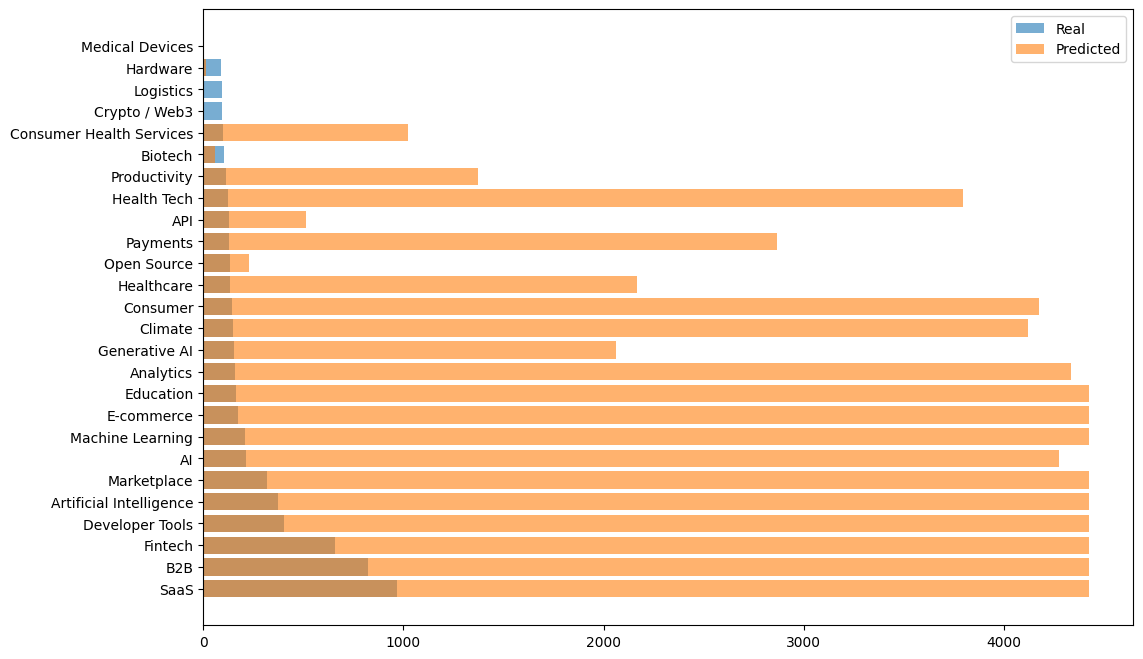

In [115]:
with localize_globals():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for label, counter in (
        ("Real", real_tag_frequencies),
        ("Predicted", pred_tag_frequencies),
    ):
        n: typing.Final[int] = 25
        
        top_n: list[tuple[str, int]] = counter.most_common(n)
        
        x, y = zip(*top_n)
        
        ax.barh(x, y, label=label, alpha=0.6)
    
    ax.legend()
